# Gemini API: Analyze a Video - Summarization

This notebook shows how you can use Gemini API's multimodal capabilities for video summarization.


## Setup

### Install the Google GenAI SDK

Install the Google GenAI SDK from [npm](https://www.npmjs.com/package/@google/genai). 

```bash
$ npm install @google/genai
```

### Setup your API key

You can [create](https://aistudio.google.com/app/apikey) your API key using Google AI Studio with a single click.

Remember to treat your API key like a password. Don't accidentally save it in a notebook or source file you later commit to GitHub. In this notebook we will be storing the API key in a `.env` file. You can also set it as an environment variable or use a secret manager. 

Here's how to set it up in a `.env` file:

```bash
$ touch .env
$ echo "GEMINI_API_KEY=<YOUR_API_KEY>" >> .env
```

:::{.callout-tip}

Another option is to set the API key as an environment variable. You can do this in your terminal with the following command:

```bash
$ export GEMINI_API_KEY="<YOUR_API_KEY>"
```
:::

### Load the API key

To load the API key from the `.env` file, we will use the `dotenv` package. This package loads environment variables from a `.env` file into `process.env`. 

```bash
$ npm install dotenv
```

Then, we can load the API key in our code:


In [15]:
const dotenv = require("dotenv") as typeof import("dotenv");

dotenv.config({
  path: "../.env",
});

const GEMINI_API_KEY = process.env.GEMINI_API_KEY ?? "";
if (!GEMINI_API_KEY) {
  throw new Error("GEMINI_API_KEY is not set in the environment variables");
}
console.log("GEMINI_API_KEY is set in the environment variables");


GEMINI_API_KEY is set in the environment variables


:::{.callout-note}
In our particular case the `.env` is is one directory up from the notebook, hence we need to use `../` to go up one directory. If the `.env` file is in the same directory as the notebook, you can omit it altogether. 

```
│
├── .env
└── examples
    └── Analyze_a_Video_Summarization.ipynb
```
:::


### Initialize SDK Client

With the new SDK, now you only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.


In [16]:
const google = require("@google/genai") as typeof import("@google/genai");

const ai = new google.GoogleGenAI({ apiKey: GEMINI_API_KEY });


### Select a model

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](quickstarts/Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).


In [17]:
const tslab = require("tslab") as typeof import("tslab");

const MODEL_ID = "gemini-2.5-flash-preview-05-20";


## Example

This notebook will use [Wing It!](https://studio.blender.org/films/wing-it/) movie directed by Rik Schutte, wills falls under the [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/deed.en).

See the full [credits](https://studio.blender.org/films/wing-it/pages/credits/) for all of the other people involved in its creation.


In [18]:
const fs = require("fs") as typeof import("fs");
const path = require("path") as typeof import("path");

const downloadFile = async (url: string, filePath: string) => {
  const response = await fetch(url);
  if (!response.ok) {
    throw new Error(`Failed to download file: ${response.statusText}`);
  }
  fs.mkdirSync(path.dirname(filePath), { recursive: true });
  const buffer = await response.blob();
  const bufferData = Buffer.from(await buffer.arrayBuffer());
  fs.writeFileSync(filePath, bufferData);
};


In [19]:
const VIDEO_URL = "https://upload.wikimedia.org/wikipedia/commons/3/38/WING_IT%21_-_Blender_Open_Movie-full_movie.webm";
const VIDEO_FILE_PATH = path.join("../assets/examples", "Wing_It.webm");
await downloadFile(VIDEO_URL, VIDEO_FILE_PATH);


Upload the file using the File API so its easier to pass it to the model later on.


In [20]:
import { File, FileState } from "@google/genai";

async function deferredFileUpload(filePath: string, config: { displayName: string }): Promise<File> {
  const file = await ai.files.upload({
    file: filePath,
    config,
  });
  let getFile = await ai.files.get({ name: file.name ?? "" });
  while (getFile.state === FileState.PROCESSING) {
    getFile = await ai.files.get({ name: file.name ?? "" });
    console.log(`current file status (${getFile.displayName}): ${getFile.state ?? "unknown"}`);
    console.log("File is still processing, retrying in 5 seconds");

    await new Promise((resolve) => {
      setTimeout(resolve, 5000);
    });
  }
  if (file.state === FileState.FAILED) {
    throw new Error("File processing failed.");
  }
  return file;
}


In [21]:
const videoFile = await deferredFileUpload(VIDEO_FILE_PATH, {
    displayName: "Wing It! - Full Movie",
});


current file status (Wing It! - Full Movie): PROCESSING
File is still processing, retrying in 5 seconds
current file status (Wing It! - Full Movie): PROCESSING
File is still processing, retrying in 5 seconds
current file status (Wing It! - Full Movie): PROCESSING
File is still processing, retrying in 5 seconds
current file status (Wing It! - Full Movie): ACTIVE
File is still processing, retrying in 5 seconds


To demonstrate the video content, display the one of the frames:


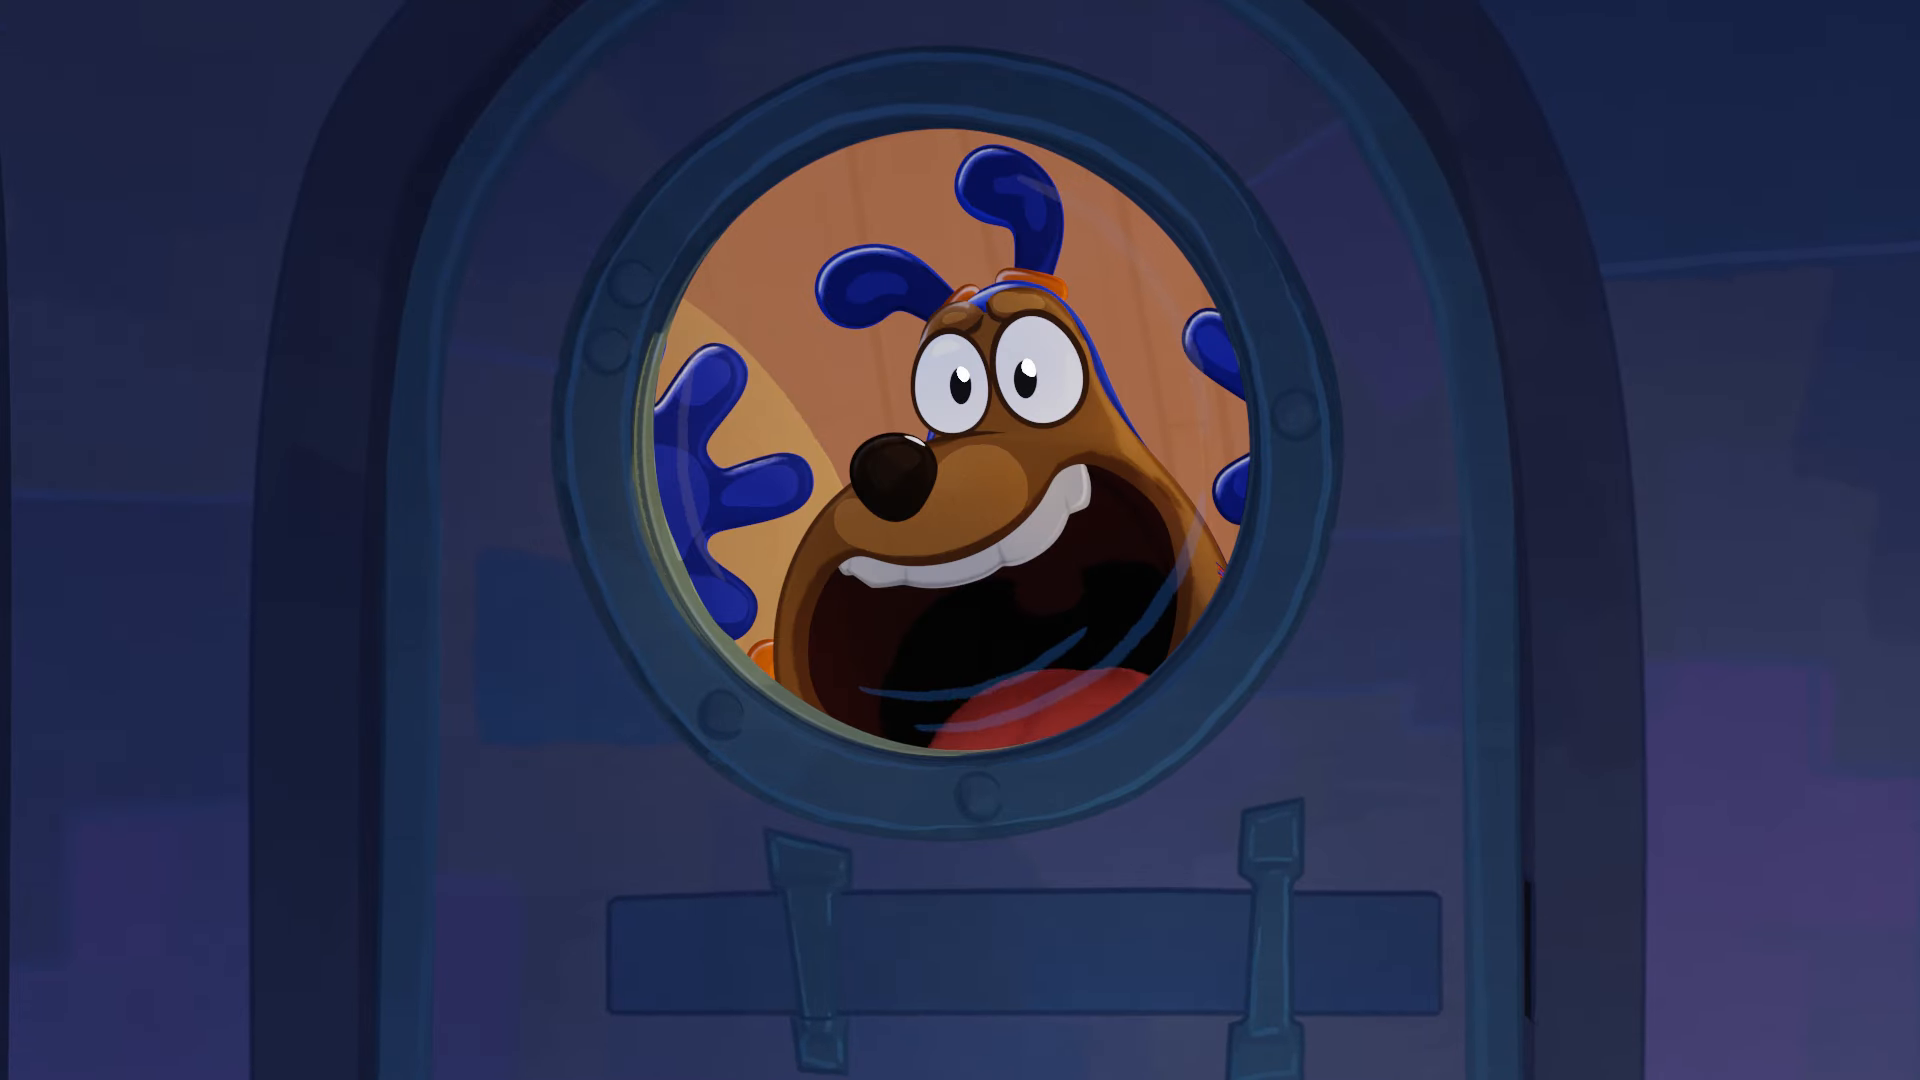

In [ ]:
const ffmpeg = require("fluent-ffmpeg") as typeof import("fluent-ffmpeg");
const stream = require("stream") as typeof import("stream");

function getFirstFrameBuffer(videoPath: string, codec = "png"): Promise<Buffer> {
  return new Promise((resolve, reject) => {
    const passthrough = new stream.PassThrough();
    const chunks: Buffer[] = [];

    ffmpeg(videoPath)
      .seekInput("00:00:37")
      .input(videoPath)
      .outputOptions(["-vframes", "1", "-vcodec", codec])
      .format("image2pipe")
      .on("error", reject)
      .on("end", () => {
        resolve(Buffer.concat(chunks));
      })
      .pipe(passthrough, { end: true });

    passthrough.on("data", (chunk: Buffer) => chunks.push(chunk));
    passthrough.on("error", reject);
  });
}

const firstFrameBuffer = await getFirstFrameBuffer(VIDEO_FILE_PATH, "png");
tslab.display.png(new Uint8Array(firstFrameBuffer));


The video is now ready to be summarized by the model.


In [30]:
const response = await ai.models.generateContent({
    model: MODEL_ID,
    contents: [
        "Summarise this video please.",
        google.createPartFromUri(videoFile.uri ?? "", videoFile.mimeType ?? "video/webm"),
    ],
    config: {
        systemInstruction: "You should provide a quick 2 or 3 sentence summary of what is happening in the video."
    },
});
tslab.display.markdown(response.text ?? "No response text available.");


This animated short features a cat meticulously building an airplane in a barn, only for his boisterous dog companion to eagerly commandeer the controls. The dog's chaotic attempts to fly cause the plane to fall apart mid-air, but the resourceful cat manages to reassemble it into a makeshift flying machine. After successfully soaring through the sky, they hilariously crash back into the barn, completing their "pet project."

The model correctly describes the plot of the short movie.

Now, you can delete the no longer necessary uploaded file.


In [31]:
await ai.files.delete({
    name: videoFile.name ?? "",
});


DeleteFileResponse {}


:::{.callout-important}

Gemini API takes only one frame per second of the video. It may cause models not to see everything that is happening, especially if something is visible only for a fraction of a second.

:::


## Summary

Now you know how you can use Gemini models to summarize what is happening in videos.

This notebook shows only one of many use cases. Check the [Video understanding notebook](../quickstarts/Video_understanding.ipynb) for more examples of using the Gemini API with videos.
